### **Import libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import io
import os

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import cv2
import glob

### **Set the random seed**

In [2]:
seed = 3
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### **Load and preprocess data**

In [3]:
import zipfile

#unzip BDRW_train_1.zip
z = zipfile.ZipFile('../input/bdrw/BDRW_train/BDRW_train_1.zip', "r")
for name in z.namelist():
    z.extract(name)
    
#unzip BDRW_train_2.zip    
z = zipfile.ZipFile('../input/bdrw/BDRW_train/BDRW_train_2.zip', "r")
for name in z.namelist():
    z.extract(name)

In [4]:
#read the excel file-labels.xls containing the image labels
labels = pd.read_excel('BDRW_train_2/labels.xls')
labels.columns = ['digit', 'label']

In [5]:
#view the labels dataframe
labels.head()

,digit,label
0,digit_1,4
1,digit_2,2
2,digit_3,3
3,digit_4,1
4,digit_5,2


### **Check the class distribution**

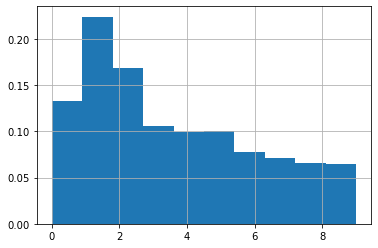

In [6]:
#Plot a histogram with x-axis : class label, y-axis : percentage of data in that class
labels['label'].hist(density = True)

### **Read the images**

In [7]:
bdrw_train_1 = [f[13:-4] for f in glob.glob("BDRW_train_1/*")] #list of image names in BDRW_train_1 folder
bdrw_train_2 = [f[13:-4] for f in glob.glob("BDRW_train_2/*")] #list of image names in BDRW_train_2 folder

print('Number of images in BDRW_train_1: ', len(bdrw_train_1))
print('Number of images in BDRW_train_2: ', len(bdrw_train_2))

print('First 5 images in BDRW_train_1:', bdrw_train_1[:5])
print('First 5 images in BDRW_train_2:', bdrw_train_2[:5])

Number of images in BDRW_train_1:  984
Number of images in BDRW_train_2:  410
First 5 images in BDRW_train_1: ['digit_433', 'digit_695', 'digit_956', 'digit_897', 'digit_26']
First 5 images in BDRW_train_2: ['digit_1377', 'digit_1226', 'digit_1188', 'digit_1373', 'digit_1199']


In [8]:
size = 32 #size of the resized image
X = []

for i,row in labels.iterrows(): #loop across the rows of the 'labels' dataframe
    
    #read the image in the 'digit' column of 'labels' dataframe
    if(row['digit'] in bdrw_train_1): #if the image is in BDRW_train_1 folder
        image = cv2.imread('BDRW_train_1/' + row['digit'] + ".jpg", 0)  
    else:  #if the image is in BDRW_train_2 folder
        image = cv2.imread('BDRW_train_2/' + row['digit'] + ".jpg", 0)
        
    image = cv2.resize(image, dsize = (size,size)) #resize the image
    X.append(image) #append the image to the list

X = np.array(X) #convert the image into numpy array
X = X/float(255.0) #normalize the values
y = labels['label'].values #get the labels

print("Shape of X: ", X.shape, "\t Shape of y: ", y.shape)

Shape of X:  (1392, 32, 32) 	 Shape of y:  (1392,)


### **Train-Test-Validation Split**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, random_state = 25, stratify = y) #put 70% data in train

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = 25, stratify = y_test) #put 15% data in test and validation each

print("Shape of train data: \t\t", (X_train.shape, y_train.shape))
print("Shape of validation data: \t", (X_val.shape, y_val.shape))
print("Shape of test data: \t\t", (X_test.shape, y_test.shape))

Shape of train data: 		 ((974, 32, 32), (974,))
Shape of validation data: 	 ((209, 32, 32), (209,))
Shape of test data: 		 ((209, 32, 32), (209,))


### **Convert the data into usable torch format**

In [10]:
# converting training images into torch format
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_train  = torch.from_numpy(X_train)

# converting the training labels into torch format
y_train = y_train.astype(int);
y_train = torch.from_numpy(y_train)
y_train = y_train.squeeze()

# shape of training data
print("Shape of train data, \t X : ", X_train.shape,"\t and y: ", y_train.shape)

# converting validation images into torch format
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_val  = torch.from_numpy(X_val)

# converting the validation labels into torch format
y_val = y_val.astype(int);
y_val = torch.from_numpy(y_val)
y_val = y_val.squeeze()

# shape of validation data
print("Shape of val. data, \t X : ", X_val.shape,"\t and y: ", y_val.shape) 

# converting test images into torch format
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
X_test  = torch.from_numpy(X_test)

# converting the test labels into torch format
y_test = y_test.astype(int);
y_test = torch.from_numpy(y_test)
y_test = y_test.squeeze()

# shape of test data
print("Shape of test data, \t X : ", X_test.shape,"\t and y: ", y_test.shape) 

Shape of train data, 	 X :  torch.Size([974, 1, 32, 32]) 	 and y:  torch.Size([974])
Shape of val. data, 	 X :  torch.Size([209, 1, 32, 32]) 	 and y:  torch.Size([209])
Shape of test data, 	 X :  torch.Size([209, 1, 32, 32]) 	 and y:  torch.Size([209])


### **Function to create minibatches**

In [11]:
def random_mini_batches(X, Y, mini_batch_size = 32, seed = 3):
    
    np.random.seed(seed)            
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation].reshape((m,1))

    # Step 2: Partition (shuffled_X, shuffled_Y). Excluding the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of complete mini batches of size mini_batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[mini_batch_size*k : mini_batch_size*(k+1), :, :, :]
        mini_batch_Y = shuffled_Y[mini_batch_size*k : mini_batch_size*(k+1), :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[mini_batch_size*num_complete_minibatches : , :, :, :]
        mini_batch_Y = shuffled_Y[mini_batch_size*num_complete_minibatches : , :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### **Define the Network Architechture**

In [12]:
#An architechture inspired from the famous LeNet5 architechture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size = 5, stride = 1, padding = 0) #input size:1*32*32 , output size: 6*28*28 
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2) #input size:6*28*28 , output size: 6*14*14 
        self.batch_norm_1 = nn.BatchNorm2d(6) #normalizes the input to the next conv2d layer
        self.conv2 = nn.Conv2d(6, 16, kernel_size = 5, stride = 1, padding = 0) #input size:6*14*14 , output size: 16*10*10 
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2) #input size:16*10*10 , output size:16*5*5 
        self.batch_norm_2 = nn.BatchNorm2d(16) #normalizes the input to the next fully connected layer
        self.fc1 = nn.Linear(16*5*5, 120) #input size:16*5*5 , output size: 120
        self.dropout_1 = nn.Dropout(p = 0.5) #dropout for regularization (to prevent overfitting on the train set)
        self.fc2 = nn.Linear(120, 84) #input size:120 , output size: 84
        self.dropout_2 = nn.Dropout(p = 0.5) #dropout for regularization (to prevent overfitting on the train set)
        self.fc3 = nn.Linear(84, 10) #input size:84 , output size: 10 (no. of classes for our problem)

#define the data flow
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.max_pool_1(x)
        x = self.batch_norm_1(x)
        x = x = F.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = self.batch_norm_2(x)
        x = x.view(-1, 16*5*5) #reshape for input to the fully connected layer 1 (fc1)
        x = F.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

### **Define model, optimizer, loss function**

In [13]:
# defining the model
model = Net()
model = model.float()

# defining the optimizer
learning_rate = 0.0004
optimizer = optim.Adam(model.parameters(), lr = learning_rate) #Adam optimizer

# defining the loss function
values, counts = np.unique(y_train.float(), return_counts = True)
weights = sum(counts)/counts
weights = torch.tensor(weights, dtype = torch.float)
criterion = nn.CrossEntropyLoss(weight = weights) #weights used to deal with the Class Imbalance problem

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model) 

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm_1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout_1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### **Training function**

In [14]:
def train(epoch, X_train, y_train, X_val, y_val):
    
    model.train()

    # converting the data into GPU format
    if torch.cuda.is_available():
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        X_val = X_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(X_train.float())
    output_val = model(X_val.float())
    
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train.long())
    loss_val = criterion(output_val, y_val.long())
        
    # computing the predictions for training and validation set
    preds_train = torch.argmax(output_train,dim=1)
    preds_val = torch.argmax(output_val,dim=1)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()

    return((loss_val, preds_val), (loss_train, preds_train))

### **Training the dataset**

In [15]:
seed = 3 #random seed
n_epochs = 50 #number of epochs
mini_batch_size = 16 #size of the mini batch
m = X_train.shape[0] #no of training examples
n_batches = np.ceil(y_train.shape[0]/mini_batch_size) #no of batches

# empty lists to store training losses, accuracy
train_losses = []
train_accuracy = []

# empty lists to store validation losses, accuracy
val_losses = []
val_accuracy = []

# training the model
for epoch in range(n_epochs):
    
    val_running_loss = 0
    val_running_corr = 0
    train_running_loss = 0
    train_running_corr = 0
    seed += 1 #change the seed to reshuffle the dataset differently after each epoch 
    minibatches = random_mini_batches(X_train, y_train, mini_batch_size, seed) #get the minibacthes
    i = 0
    
    for minibatch in minibatches:
        
        (minibatch_X, minibatch_Y) = minibatch
        size = minibatch_Y.shape[0] #get the size of minibatch_Y
        minibatch_Y = torch.reshape(minibatch_Y, (size,)) #reshape appropriately 
        (loss_val, preds_val), (loss_train, preds_train) = train(epoch, minibatch_X, minibatch_Y, X_val, y_val) #get the losses and predictions after training
        
        val_running_loss += loss_val 
        val_running_corr += torch.sum(preds_val == y_val.long())
        train_running_loss += loss_train 
        train_running_corr += torch.sum(preds_train == minibatch_Y.long())
        i = i+1
        
    val_epoch_loss = val_running_loss.item()/i
    val_epoch_acc = val_running_corr.item()/(X_val.shape[0] * i)
    if((epoch+1)%2 == 0):
        print('Epoch {:.0f}/{:.0f} : Validation loss: {:.4f} | Validation Accuracy: {:.4f}'.format(epoch+1,n_epochs,val_epoch_loss,val_epoch_acc*100))
    
    train_epoch_loss = train_running_loss.item()/i
    train_epoch_acc = train_running_corr.item()/X_train.shape[0]
    
    #append the losses and accuracies to the lists
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracy.append(train_epoch_acc)
    val_accuracy.append(val_epoch_acc)

Epoch 2/50 : Validation loss: 2.1288 | Validation Accuracy: 30.4730
Epoch 4/50 : Validation loss: 1.4082 | Validation Accuracy: 55.0553
Epoch 6/50 : Validation loss: 0.9292 | Validation Accuracy: 68.7505
Epoch 8/50 : Validation loss: 0.6895 | Validation Accuracy: 76.7746
Epoch 10/50 : Validation loss: 0.5374 | Validation Accuracy: 82.0927
Epoch 12/50 : Validation loss: 0.4732 | Validation Accuracy: 84.0850
Epoch 14/50 : Validation loss: 0.4149 | Validation Accuracy: 85.8891
Epoch 16/50 : Validation loss: 0.3836 | Validation Accuracy: 87.1676
Epoch 18/50 : Validation loss: 0.3620 | Validation Accuracy: 88.2657
Epoch 20/50 : Validation loss: 0.3292 | Validation Accuracy: 88.9168
Epoch 22/50 : Validation loss: 0.3095 | Validation Accuracy: 89.4972
Epoch 24/50 : Validation loss: 0.2920 | Validation Accuracy: 89.9992
Epoch 26/50 : Validation loss: 0.2749 | Validation Accuracy: 90.5326
Epoch 28/50 : Validation loss: 0.2763 | Validation Accuracy: 90.5953
Epoch 30/50 : Validation loss: 0.2645 

### **Plot the training and validation loss curves**

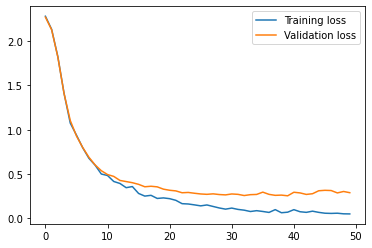

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

### **Check the model accuracy on the unseen test set**

In [17]:
if torch.cuda.is_available():
    X_test = X_test.cuda()
    y_test = y_test.cuda()
output_test = model(X_test.float())
output_test = torch.exp(output_test)
preds_test =  torch.argmax(output_test,dim=1)
test_acc = 100*torch.sum(preds_test == y_test.long()).item()/len(y_test)
print('Testing accuracy is: %0.4f'%test_acc)

Testing accuracy is: 89.4737


### **Model complexity calculations**

1. **Conv2d layer 1:** #input size: 1x32x32 , output size: 6x28x28 <br>
Params = (cwh + 1)k = ((1 * 5 * 5) + 1) * 6 = 156 <br>
Flops = (cwh + 1)k * Ow * Oh = ((1 * 5 * 5) + 1) * 6 * 28 * 28 = 122304 <br>

2. **ReLU:** #input size: 6x28x28  , output size: 6x28x28 <br>
Params = 0 <br>
Flops = 2cMN = 2 * 6 * 28 * 28 = 9408 <br>

3. **Max pool layer 1:** #input size: 6x28x28  , output size: 6x14x14 <br>
Params = 0 <br>
Flops = c*(wh - 1) * Ow * Oh = 6 * ((2 * 2) - 1) * 14 * 14 = 3528 <br>

4. **Conv2d layer 2:** #input size: 6x14x14  , output size: 16x10x10  <br>
Params = (cwh + 1)k = ((6 * 5 * 5) + 1) * 16 = 2416 <br>
Flops = (cwh + 1)k * Ow * Oh = ((6 * 5 * 5) + 1) * 16 * 10 * 10 = 241600 <br>

5. **ReLU:** #input size:  16x10x10   , output size:  16x10x10   <br>
Params = 0 <br>
Flops = 2cMN = 2 * 16 * 10 * 10 = 3200 <br>

6. **Max pool layer 2:** #input size: 16x10x10  , output size: 16x5x5  <br>
Params = 0 <br>
Flops = c*(wh - 1) * Ow * Oh = 16*((2 * 2) - 1) * 5 * 5 = 1200 <br>

7. **Fully connected layer 1:** #input size: 16x5x5, output size: 120 <br>
Params = (n + 1)k = (16 * 5 * 5 + 1) * 120 = 48120 <br>
Flops = (n + 1)k = (16 * 5 * 5 + 1) * 120 = 48120 <br>

8. **ReLU:** #input size: 120, output size: 120 <br>
Params = 0 <br>
Flops = 2n = 2 * 120 = 240 <br>

9. **Fully connected layer 2:** #input size: 120, output size: 84 <br>
Params = (n + 1)k = (120 + 1) * 84 = 10164 <br>
Flops = (n + 1)k = (120 + 1) * 84 = 10164 <br>

10. **ReLU:** #input size: 84, output size: 84 <br>
Params = 0 <br>
Flops = 2n = 2 * 84 = 168 <br>

11. **Fully connected layer 3:** #input size: 84, output size: 10 <br>
Params = (n + 1)k = (84 + 1) * 10 = 850 <br>
Flops = (n + 1)k = (84 + 1) * 10 = 850 <br>

**Total Params = 61,706 <br>
Total FLOPS = 440,782 <br>**

Note: Assuming that #params and #flops for dropout and batch normalization layers ~ 0